In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sqlite3
from random import shuffle

In [17]:
LABEL_DRIL = 0
LABEL_NODRIL = 1
def split_dataset(ds):
    shuffle(ds)
    train = ds[len(ds) // 2:]
    test = ds[:len(ds) // 2]
    return train, test

def load_dataset():
    with sqlite3.connect('./tweets.db') as conn:
        cur = conn.execute('SELECT * FROM tweets WHERE user = \'dril\'')
        dril_tweets = [tweet[3] for tweet in cur]
        cur = conn.execute('SELECT * FROM tweets WHERE user != \'dril\'')
        nodril_tweets = [tweet[3] for tweet in cur]

        dril_train, dril_test = split_dataset(dril_tweets)
        dril_train_lbl = [LABEL_DRIL for _ in dril_train]
        dril_test_lbl = [LABEL_DRIL for _ in dril_test]
        nodril_train, nodril_test = split_dataset(nodril_tweets)
        nodril_train_lbl = [LABEL_NODRIL for _ in nodril_train]
        nodril_test_lbl = [LABEL_NODRIL for _ in nodril_test]
        
        train_data = dril_train + nodril_train
        train_lbl = dril_train_lbl + nodril_train_lbl
        
        test_data = dril_test + nodril_test
        test_lbl = dril_test_lbl + nodril_test_lbl
        
        return (train_data, train_lbl), (test_data, test_lbl)

In [18]:
(train_x, train_y), (test_x, test_y) = load_dataset()

In [36]:
np.pad(np.array([ord(c) for c in train_x[0]]), (0, 240 - len(train_x[0])), mode='constant')

array([102, 105, 114, 115, 116,  32, 121, 111, 117,  32, 104,  97, 118,
       101,  32, 100, 101, 109, 111,  99, 114,  97, 116, 115,  32,  97,
       110, 100,  32, 114, 116, 101, 112, 117,  98, 108, 105,  99,  97,
       110, 115,  46,  32, 116, 104, 101, 121, 114, 101,  32,  98,  97,
       115, 105,  99,  97, 108, 108, 121,  32, 116, 104, 101,  32, 115,
        97, 109, 101,  32, 116, 104, 105, 110, 103,  46,  32, 116, 104,
       101, 110,  32, 121, 111, 117,  32, 104,  97, 118, 101,  32, 103,
       114, 101, 101, 110,  32, 112,  97, 114, 116, 121,  32,  97, 110,
       100,  32, 117, 104,  44,  32, 116, 104, 101,  32, 119, 104, 105,
       103, 115,  46,  32, 116, 104, 101, 121, 114, 101,  32, 116, 104,
       101,  32, 115,  97, 109, 101,  32, 116, 111, 111,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [37]:
def to_padded_bytes(tweet):
    bts = np.array([ord(c) for c in tweet])
    return np.pad(bts, (0, 240 - bts.shape[0]), mode='constant')

In [41]:
train_x = np.matrix([to_padded_bytes(x) for x in train_x])
test_x = np.matrix([to_padded_bytes(x) for x in test_x])

In [44]:
train_y = keras.utils.to_categorical(train_y)
test_y = keras.utils.to_categorical(test_y)

In [45]:
train_x.shape

(4442, 240)

In [93]:
model = keras.Sequential([
    keras.layers.Embedding(255, 16, input_length=240),
    keras.layers.Conv1D(140, 3, padding='valid', activation='relu', strides=1),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

In [94]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [95]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 240, 16)           4080      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 238, 140)          6860      
_________________________________________________________________
global_average_pooling1d_8 ( (None, 140)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               72192     
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 1026      
Total params: 84,158
Trainable params: 84,158
Non-trainable params: 0
_________________________________________________________________


In [96]:
history = model.fit(train_x, train_y, epochs=25, validation_data=(test_x, test_y))

Train on 4442 samples, validate on 4441 samples
Epoch 1/25
4442/4442 [==============================] - 1s 277us/step - loss: 0.6183 - acc: 0.6686 - val_loss: 0.5372 - val_acc: 0.6701
Epoch 2/25
4442/4442 [==============================] - 1s 158us/step - loss: 0.4750 - acc: 0.7787 - val_loss: 0.4290 - val_acc: 0.8032
Epoch 3/25
4442/4442 [==============================] - 1s 158us/step - loss: 0.4087 - acc: 0.8235 - val_loss: 0.3932 - val_acc: 0.8289
Epoch 4/25
4442/4442 [==============================] - 1s 162us/step - loss: 0.3781 - acc: 0.8406 - val_loss: 0.3728 - val_acc: 0.8376
Epoch 5/25
4442/4442 [==============================] - 1s 159us/step - loss: 0.3585 - acc: 0.8474 - val_loss: 0.3688 - val_acc: 0.8331
Epoch 6/25
4442/4442 [==============================] - 1s 158us/step - loss: 0.3445 - acc: 0.8534 - val_loss: 0.3498 - val_acc: 0.8469
Epoch 7/25
4442/4442 [==============================] - 1s 158us/step - loss: 0.3339 - acc: 0.8577 - val_loss: 0.3464 - val_acc: 0.8485


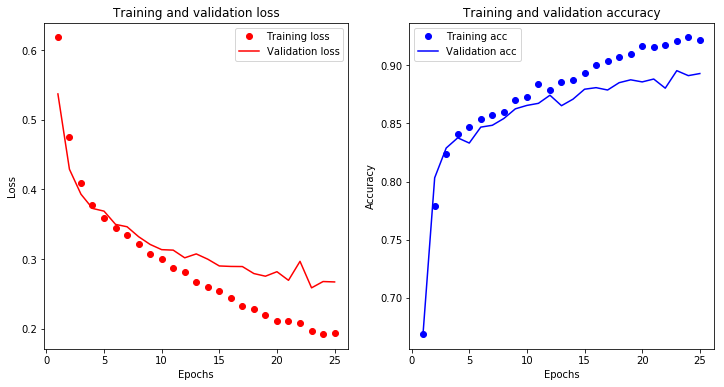

In [97]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(epochs, loss, 'ro', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

f.show()

In [108]:
user_tweet = """compiling machine learning tweets to get kicked in the ass by keras"""
user_x = to_padded_bytes(user_tweet)
user_x

array([ 99, 111, 109, 112, 105, 108, 105, 110, 103,  32, 109,  97,  99,
       104, 105, 110, 101,  32, 108, 101,  97, 114, 110, 105, 110, 103,
        32, 116, 119, 101, 101, 116, 115,  32, 116, 111,  32, 103, 101,
       116,  32, 107, 105,  99, 107, 101, 100,  32, 105, 110,  32, 116,
       104, 101,  32,  97, 115, 115,  32,  98, 121,  32, 107, 101, 114,
        97, 115,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [109]:
model.predict(np.array([user_x]))

array([[0.9883067 , 0.01169331]], dtype=float32)

In [112]:
model.save('model.h5')